In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.insert(0, '..//src/')
import pandas as pd
from project_settings import settings
from pathlib import Path
from datetime import datetime
# import kaleido
# print(kaleido.__version__)
from enum import StrEnum, auto

In [19]:
class Season(StrEnum):
    WINTER = auto()
    SUMMER = auto()
    SPRING = auto()
    AUTUMN = auto()


def get_season(month: int) -> str:
    if 3 <= month <= 5:  #April and May
        return Season.SPRING.name
    elif 6 <= month <= 8:  # June, July, August
        return Season.SUMMER.name
    elif 9 <= month <= 11:  # September, October and November
        return Season.AUTUMN.name
    else:
        return Season.WINTER.name

In [37]:
new_columns_map = {
    'Aut Wd': (Season.AUTUMN.name, 'Weekday'),
    'Aut Sat': (Season.AUTUMN.name, 'Saturday'),
    'Aut Sun': (Season.AUTUMN.name, 'Sunday'),
    'Smr Wd': (Season.SUMMER.name, 'Weekday'),
    'Smr Sat': (Season.SUMMER.name, 'Saturday'),
    'Smr Sun': (Season.SUMMER.name, 'Sunday'),
    'Spr Wd': (Season.SPRING.name, 'Weekday'),
    'Spr Sat': (Season.SPRING.name, 'Saturday'),
    'Spr Sun': (Season.SPRING.name, 'Sunday'),
    'Wtr Wd': (Season.WINTER.name, 'Weekday'),
    'Wtr Sat': (Season.WINTER.name, 'Saturday'),
    'Wtr Sun': (Season.WINTER.name, 'Sunday')
}


In [90]:
profile_classes = {
  'profile_class_3': 106,
  'profile_class_4': 158,
  'profile_class_5': 210,
  'profile_class_6': 262,
}

In [93]:
frames = []

for profile_class, skiprows in profile_classes.items():

  temp_profiles_class = pd.read_excel(settings.ELEXON_PROFILES, skiprows=skiprows)
  temp_profiles_class = temp_profiles_class.iloc[:48]
  temp_profiles_class.set_index('Settlement period', inplace=True)

  cols_to_keep = [x for x in temp_profiles_class.columns if 'Hsr' not in x]
  temp_profiles_class = temp_profiles_class[cols_to_keep]
  new_columns = [new_columns_map[x] for x in temp_profiles_class.columns]
  temp_profiles_class.columns = pd.MultiIndex.from_tuples(new_columns)
  temp_profiles_class = temp_profiles_class.stack([0,1], future_stack=True).to_frame()
  temp_profiles_class.columns = ['value']
  temp_profiles_class.reset_index(inplace=True)
  temp_profiles_class['Settlement period'] = temp_profiles_class['Settlement period'].astype(str) 
  temp_profiles_class

  datetime_index = pd.date_range(start=datetime(2023, 1, 1) , end=datetime(2023, 12, 31, 23, 30) ,freq='30min')
  dummy_data = pd.DataFrame(index=datetime_index)
  dummy_data['Season'] = dummy_data.index.month.map(get_season)
  dummy_data['Weekday_nb'] = dummy_data.index.weekday

  dummy_data['Weekday_str'] = 'Weekday'
  filt = dummy_data['Weekday_nb']==5
  dummy_data.loc[filt, 'Weekday_str'] = 'Saturday'
  filt = dummy_data['Weekday_nb']==6
  dummy_data.loc[filt, 'Weekday_str'] = 'Sunday'
  dummy_data['time'] = dummy_data.index.time.astype(str)

  dummy_data.reset_index(inplace=True)
  dummy_data

  dummy_data = pd.merge(dummy_data, temp_profiles_class, how='left', left_on=['Season', 'Weekday_str', 'time'], right_on=['level_1', 'level_2', 'Settlement period'])
  dummy_data = dummy_data[['index', 'value']]
  dummy_data.set_index('index', inplace=True)
  dummy_data.columns = [profile_class]
  frames.append(dummy_data)


In [99]:
final_dummy_data = pd.concat(frames, axis=1)

<Axes: xlabel='index,index'>

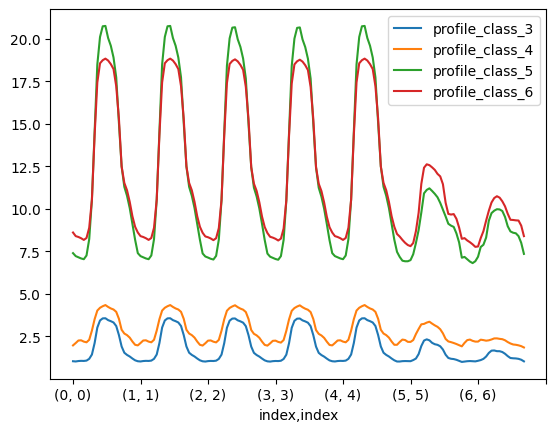

In [102]:

final_dummy_data.groupby([final_dummy_data.index.weekday, final_dummy_data.index.hour]).mean().plot()

In [103]:
final_dummy_data.sum()

profile_class_3     32327.494541
profile_class_4     49959.814532
profile_class_5    204497.153461
profile_class_6    209227.550797
dtype: object

In [104]:
final_dummy_data.to_csv(settings.PATH_SAVE_DATA / 'dummy_data.csv')